# 1. 타이타닉 생존 예측 모델

In [1]:
# ===== 필요한 패키지 설치 =====
!pip install torch torchvision torchaudio
!pip install wandb
!pip install pandas
!pip install scikit-learn

In [2]:
# ===== 환경 설정 및 라이브러리 Import =====
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset
import wandb
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# pandas 출력 설정
pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)

/opt/anaconda3/envs/link_dl/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/link_dl/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/opt/anaconda3/envs/link_dl/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` functi

In [3]:
# ===== 데이터셋 클래스 정의 =====

# 타이타닉 학습/검증 데이터셋
class TitanicDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X)
    self.y = torch.LongTensor(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str


# 타이타닉 테스트 데이터셋 (PassengerId 포함)
class TitanicTestDataset(Dataset):
  def __init__(self, X, passenger_ids):
    self.X = torch.FloatTensor(X)
    self.passenger_ids = torch.LongTensor(passenger_ids)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    passenger_id = self.passenger_ids[idx]
    return {'input': feature, 'passenger_id': passenger_id}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str

In [4]:
# ===== 데이터 전처리 함수 =====

# Pclass별 Fare (요금) 평균값을 사용하여 Fare 결측치 메우기
def get_preprocessed_dataset_1(all_df):
  Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
  Fare_mean.columns = ["Pclass", "Fare_mean"]
  all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
  all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
  all_df = all_df.drop(columns=["Fare_mean"])
  return all_df


# name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
def get_preprocessed_dataset_2(all_df):
  name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
  name_df.columns = ["family_name", "title", "name"]
  name_df["family_name"] = name_df["family_name"].str.strip()
  name_df["title"] = name_df["title"].str.strip()
  name_df["name"] = name_df["name"].str.strip()
  all_df = pd.concat([all_df, name_df], axis=1)
  return all_df


# title별 Age 평균값을 사용하여 Age 결측치 메우기
def get_preprocessed_dataset_3(all_df):
  title_age_mean = all_df[["title", "Age"]].groupby("title").median().round().reset_index()
  title_age_mean.columns = ["title", "title_age_mean", ]
  all_df = pd.merge(all_df, title_age_mean, on="title", how="left")
  all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["title_age_mean"]
  all_df = all_df.drop(["title_age_mean"], axis=1)
  return all_df


# 가족수(family_num) 컬럼 추가 및 혼자탑승(alone) 컬럼 추가, 불필요한 컬럼 제거
def get_preprocessed_dataset_4(all_df):
  # 가족수(family_num) 컬럼 새롭게 추가
  all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

  # 혼자탑승(alone) 컬럼 새롭게 추가
  all_df.loc[all_df["family_num"] == 0, "alone"] = 1
  all_df["alone"].fillna(0, inplace=True)

  # 학습에 불필요한 컬럼 제거
  all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)
  return all_df


# title 값 개수 줄이기, Embarked 결측치 메우기
def get_preprocessed_dataset_5(all_df):
  all_df.loc[
    ~(
      (all_df["title"] == "Mr") |
      (all_df["title"] == "Miss") |
      (all_df["title"] == "Mrs") |
      (all_df["title"] == "Master")
    ),
    "title"
  ] = "other"
  all_df["Embarked"].fillna("missing", inplace=True)
  return all_df


# 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
def get_preprocessed_dataset_6(all_df):
  category_features = all_df.columns[all_df.dtypes == "object"]
  for category_feature in category_features:
    le = LabelEncoder()
    if all_df[category_feature].dtypes == "object":
      le = le.fit(all_df[category_feature])
      all_df[category_feature] = le.transform(all_df[category_feature])
  return all_df


# 타이타닉 데이터셋 로드 및 전처리
# train.csv, test.csv가 있는 디렉토리 경로를 data_dir로 지정 (기본값: 현재 디렉토리)
# 반환: train_dataset, validation_dataset, test_dataset (PassengerId 포함)
def get_preprocessed_dataset(data_dir="."):
  train_data_path = os.path.join(data_dir, "train.csv")
  test_data_path = os.path.join(data_dir, "test.csv")

  train_df = pd.read_csv(train_data_path)
  test_df = pd.read_csv(test_data_path)

  all_df = pd.concat([train_df, test_df], sort=False)

  # 전처리 파이프라인 순차 실행
  all_df = get_preprocessed_dataset_1(all_df)
  all_df = get_preprocessed_dataset_2(all_df)
  all_df = get_preprocessed_dataset_3(all_df)
  all_df = get_preprocessed_dataset_4(all_df)
  all_df = get_preprocessed_dataset_5(all_df)
  all_df = get_preprocessed_dataset_6(all_df)

  print(all_df.columns)
  print(all_df.head(10))

  # PassengerId 보존 (test.csv용)
  test_passenger_ids = test_df["PassengerId"].values

  # 학습/검증 데이터 분리
  train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
  train_y = train_df["Survived"]

  # 테스트 데이터 분리
  test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
  dataset = TitanicDataset(train_X.values, train_y.values)
  print(dataset)

  # 학습:검증 = 8:2로 분할
  train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
  test_dataset = TitanicTestDataset(test_X.values, test_passenger_ids)
  print(f"Test dataset with {len(test_passenger_ids)} passengers (IDs: {test_passenger_ids[0]} to {test_passenger_ids[-1]})")

  return train_dataset, validation_dataset, test_dataset

In [5]:
# ===== 데이터 로딩 =====

# 타이타닉 데이터셋을 불러오고 DataLoader 생성
# train.csv, test.csv는 이 스크립트와 같은 디렉토리에 있어야 함
# 반환: train_data_loader (배치 단위, 매 에폭마다 섞임)
#       validation_data_loader (전체 데이터 한 번에)
#       test_data_loader (전체 데이터 한 번에, 순서 유지)
def get_data():
  # 데이터 파일 경로 설정 (노트북과 같은 디렉토리)
  script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else '.'

  # 전처리된 타이타닉 데이터셋 가져오기
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset(data_dir=script_dir)
  print(f"Train: {len(train_dataset)}, Validation: {len(validation_dataset)}, Test: {len(test_dataset)}")

  # 학습용 데이터로더: 배치 단위로 데이터를 불러오며, 매 에폭마다 순서를 섞음
  train_data_loader = DataLoader(
      dataset=train_dataset,
      batch_size=wandb.config.batch_size,
      shuffle=True)

  # 검증용 데이터로더: 전체 검증 데이터를 한 번에 처리
  validation_data_loader = DataLoader(
      dataset=validation_dataset,
      batch_size=len(validation_dataset)
  )

  # 테스트용 데이터로더: 전체 테스트 데이터를 한 번에 처리 (순서 유지)
  # shuffle=False: Kaggle 제출 시 PassengerId 순서를 유지해야 함
  test_data_loader = DataLoader(
      dataset=test_dataset,
      batch_size=len(test_dataset),
      shuffle=False
  )

  return train_data_loader, validation_data_loader, test_data_loader

In [6]:
# ===== 모델 아키텍처 정의 =====

# 타이타닉 생존 예측을 위한 신경망 모델
# - 동적 활성화 함수 선택: 생성자에서 activation 파라미터로 함수 종류 지정
# - 이진 분류 출력: 출력층 뉴런 1개 (생존 확률 예측)
# [모델 구조] 입력층(10) → 은닉층1(20) → 활성화 함수 → 은닉층2(20) → 활성화 함수 → 출력층(1)
# [활성화 함수] sigmoid, relu, elu, leaky_relu
class MyModel(nn.Module):
  def __init__(self, n_input, n_output, activation='relu'):
    super().__init__()

    # 활성화 함수 동적 선택
    if activation == 'sigmoid':
      act_fn = nn.Sigmoid()
    elif activation == 'relu':
      act_fn = nn.ReLU()
    elif activation == 'elu':
      act_fn = nn.ELU()
    elif activation == 'leaky_relu':
      act_fn = nn.LeakyReLU()
    else:
      raise ValueError(f"지원하지 않는 활성화 함수: {activation}")

    # 신경망 모델 구조 정의
    self.model = nn.Sequential(
      nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
      act_fn,
      nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
      act_fn,
      nn.Linear(wandb.config.n_hidden_unit_list[1], n_output),
    )

  def forward(self, x):
    x = self.model(x)
    return x


# 모델과 옵티마이저 생성
# 반환: my_model (신경망 모델), optimizer (SGD 옵티마이저)
def get_model_and_optimizer():
  my_model = MyModel(
      n_input=10,
      n_output=1,
      activation=wandb.config.activation
  )
  optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)
  return my_model, optimizer

In [7]:
# ===== 학습 인프라 (Early Stopping & Training Loop) =====

# Validation loss가 개선되지 않으면 학습을 조기 종료하는 클래스
class EarlyStopping:
  def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience  # 몇 번까지 개선 없음을 허용할지
    self.counter = 0  # 개선 없는 에폭 카운터
    self.delta = delta  # 최소 개선 threshold

    self.val_loss_min = None  # 최소 validation loss 기록
    # 체크포인트 파일 경로 (타임스탬프 포함)
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    # 최신 체크포인트 파일 경로
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    # 첫 에폭인 경우
    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    # Validation loss가 개선된 경우
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0  # 카운터 리셋
    # Validation loss가 개선되지 않은 경우
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      # Patience 초과 시 조기 종료
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    # Validation loss가 감소할 때 모델 저장
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss


# 모델 학습 루프 (Early Stopping 포함)
# 반환: dict (Best 모델 체크포인트 정보) 또는 None
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
  n_epochs = wandb.config.epochs
  loss_fn = nn.BCEWithLogitsLoss()
  next_print_epoch = 100

  # Early Stopping 초기화
  early_stopping = None
  if wandb.config.get('early_stopping', False):
    from datetime import datetime
    run_time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    checkpoint_dir = "checkpoints"

    # 체크포인트 디렉토리 생성
    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    early_stopping = EarlyStopping(
      patience=wandb.config.get('patience', 1000),
      delta=wandb.config.get('early_stop_delta', 0.00001),
      project_name="titanic",
      checkpoint_file_path=checkpoint_dir,
      run_time_str=run_time_str
    )

  for epoch in range(1, n_epochs + 1):
    # ===== 학습 단계 =====
    loss_train = 0.0
    num_trains = 0
    for train_batch in train_data_loader:
      input, target = train_batch['input'], train_batch['target']
      target = target.float().unsqueeze(1)

      # Forward pass
      output_train = model(input)
      loss = loss_fn(output_train, target)
      loss_train += loss.item()
      num_trains += 1

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # ===== 검증 단계 =====
    loss_validation = 0.0
    num_validations = 0
    with torch.no_grad():
      for validation_batch in validation_data_loader:
        input, target = validation_batch['input'], validation_batch['target']
        target = target.float().unsqueeze(1)

        output_validation = model(input)
        loss = loss_fn(output_validation, target)
        loss_validation += loss.item()
        num_validations += 1

    avg_val_loss = loss_validation / num_validations

    # WandB에 학습 결과 로깅
    wandb.log({
      "Epoch": epoch,
      "Training loss": loss_train / num_trains,
      "Validation loss": avg_val_loss
    })

    # ===== Early Stopping 체크 =====
    if early_stopping:
      message, early_stop = early_stopping.check_and_save(avg_val_loss, model)

      # 주기적으로 또는 조기 종료 시 출력
      if epoch >= next_print_epoch or early_stop:
        print(
          f"Epoch {epoch}, "
          f"Training loss {loss_train / num_trains:.4f}, "
          f"Validation loss {avg_val_loss:.4f} | "
          f"{message}"
        )
        if epoch >= next_print_epoch:
          next_print_epoch += 100

      # Early stop 조건 충족 시 학습 종료
      if early_stop:
        break
    else:
      if epoch >= next_print_epoch:
        print(
          f"Epoch {epoch}, "
          f"Training loss {loss_train / num_trains:.4f}, "
          f"Validation loss {avg_val_loss:.4f}"
        )
        next_print_epoch += 100

  # Best 모델 체크포인트 정보 반환
  if early_stopping:
    return {
      'checkpoint_file_path': early_stopping.latest_file_path,
      'best_val_loss': early_stopping.val_loss_min
    }
  return None

In [8]:
# ===== 예측 및 제출 파일 생성 =====

# 테스트 데이터로 예측을 수행하고 Kaggle 제출용 submission.csv 파일 생성
# 반환: pd.DataFrame (생성된 submission 데이터프레임)
def generate_submission(model, test_data_loader, filename='submission.csv'):
  model.eval()

  predictions = []
  passenger_ids = []

  with torch.no_grad():
    for test_batch in test_data_loader:
      inputs = test_batch['input']
      ids = test_batch['passenger_id']

      # 모델 예측
      outputs = model(inputs)
      probs = torch.sigmoid(outputs)
      survived = (probs > 0.5).int().squeeze()

      # 결과 수집
      predictions.extend(survived.cpu().numpy().tolist())
      passenger_ids.extend(ids.cpu().numpy().tolist())

  # DataFrame 생성 및 정렬
  submission_df = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': predictions
  })

  submission_df = submission_df.sort_values('PassengerId').reset_index(drop=True)
  submission_df.to_csv(filename, index=False)

  print(f"✅ Submission: {filename} ({len(predictions)} predictions)")

  return submission_df

In [9]:
# ===== Main 함수 =====

# 메인 실행 함수
def main(args):
  # WandB 설정 구성
  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'learning_rate': args.learning_rate,
    'n_hidden_unit_list': [20, 20],
    'activation': args.activation,
    'early_stopping': args.early_stop,
    'patience': args.patience,
    'early_stop_delta': 0.00001,
    'save_best_submission': args.save_best_submission,
  }

  # 실험 이름 생성
  experiment_name = f"{args.activation}_ep{args.epochs}_b{args.batch_size}_lr{args.learning_rate}"
  if args.early_stop:
    experiment_name += f"_es{args.patience}"

  # WandB 초기화
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project="titanic_survival_prediction",
    notes=f"Activation: {args.activation}, LR: {args.learning_rate}, Batch: {args.batch_size}, Epochs: {args.epochs}, Early Stop: {args.early_stop}",
    tags=["titanic", "binary_classification", f"activation:{args.activation}", f"lr:{args.learning_rate}", f"batch:{args.batch_size}"],
    name=experiment_name,
    config=config
  )
  print(args)
  print(wandb.config)

  # 데이터 로더 준비
  train_data_loader, validation_data_loader, test_data_loader = get_data()

  # 모델과 옵티마이저 생성
  my_model, optimizer = get_model_and_optimizer()

  print("#" * 50, 1)

  # 학습 루프 실행
  best_info = training_loop(
    model=my_model,
    optimizer=optimizer,
    train_data_loader=train_data_loader,
    validation_data_loader=validation_data_loader
  )

  # Best model 로드 (Early Stopping이 활성화된 경우)
  if best_info and 'checkpoint_file_path' in best_info:
    my_model.load_state_dict(torch.load(best_info['checkpoint_file_path']))
    print(f"✅ Best model loaded from {best_info['checkpoint_file_path']}")

  # Submission 파일 생성
  if args.generate_submission:
    if best_info:
      submission_filename = f"submission_{experiment_name}_best_val{best_info['best_val_loss']:.4f}.csv"
    else:
      submission_filename = f"submission_{experiment_name}_final.csv"

    generate_submission(my_model, test_data_loader, filename=submission_filename)

  wandb.finish()

In [ ]:
# ===== 실행 설정 및 학습 시작 =====

# 하이퍼파라미터 설정 (원하는 값으로 수정 가능)
class Args:
    wandb = False                  # WandB 로깅 활성화 여부
    batch_size = 64                # 배치 크기
    epochs = 20000                 # 학습 에폭 수
    activation = "relu"            # 활성화 함수 (sigmoid, relu, elu, leaky_relu)
    learning_rate = 0.0005         # 학습률
    early_stop = True              # Early Stopping 활성화
    patience = 1000                # Early Stopping patience
    generate_submission = True     # 학습 후 submission.csv 생성
    save_best_submission = False   # Best validation epoch마다 submission 저장

args = Args()

# 학습 시작
main(args)

{'epochs': 20000, 'batch_size': 64, 'learning_rate': 0.0005, 'n_hidden_unit_list': [20, 20], 'activation': 'relu', 'early_stopping': True, 'patience': 1000, 'early_stop_delta': 1e-05, 'save_best_submission': False}
Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  \
0       0.0       3    1  22.0      1      0   7.2500         2      2   
1       1.0       1    0  38.0      1      0  71.2833         0      3   
2       1.0       3    0  26.0      0      0   7.9250         2      1   
3       1.0       1    0  35.0      1      0  53.1000         2      3   
4       0.0       3    1  35.0      0      0   8.0500         2      2   
5       0.0       3    1  29.0      0      0   8.4583         1      2   
6       0.0       1    1  54.0      0      0  51.8625         2      2   
7       0.0       3    1   2.0      3      1  21.0

/var/folders/f6/lv1yszks27z5fq92lw3_qz9h0000gn/T/ipykernel_50255/1502502011.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
/var/folders/f6/lv1yszks27z5fq92lw3_qz9h0000gn/T/ipykernel_50255/1502502011.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

################################################## 1
Epoch 100, Training loss 0.5913, Validation loss 0.6599 | Early stopping counter: 14 out of 1000
Epoch 200, Training loss 0.5833, Validation loss 0.6589 | Early stopping counter: 114 out of 1000
Epoch 300, Training loss 0.5908, Validation loss 0.6558 | Early stopping counter: 24 out of 1000
Epoch 400, Training loss 0.5839, Validation loss 0.6491 | Early stopping counter: 30 out of 1000
Epoch 500, Training loss 0.5699, Validation loss 0.6448 | Early stopping counter: 9 out of 1000
Epoch 600, Training loss 0.5848, Validation loss 0.6481 | Early stopping counter: 37 out of 1000
Epoch 700, Training loss 0.5881, Validation loss 0.6404 | Early stopping counter: 7 out of 1000
Epoch 800, Training loss 0.5686, Validation loss 0.6347 | Early stopping counter: 1 out of 1000
Epoch 900, Training loss 0.5819, Validation loss 0.6416 | Early stopping counter: 101 out of 1000
Epoch 1000, Training loss 0.5694, Validation loss 0.6358 | Early stopping c

## WanDB 훈련 URL
- validation loss : https://wandb.ai/changyeony-koreatech/titanic_survival_prediction/runs/67mzsgfm?nw=nwuserchangyeony&panelDisplayName=Validation+loss&panelSectionName=Charts
- training loss : https://wandb.ai/changyeony-koreatech/titanic_survival_prediction/runs/67mzsgfm?nw=nwuserchangyeony&panelDisplayName=Training+loss&panelSectionName=Charts

# 2. Activation Function & Batch Size 비교
## Activation Function 비교
### sigmoid
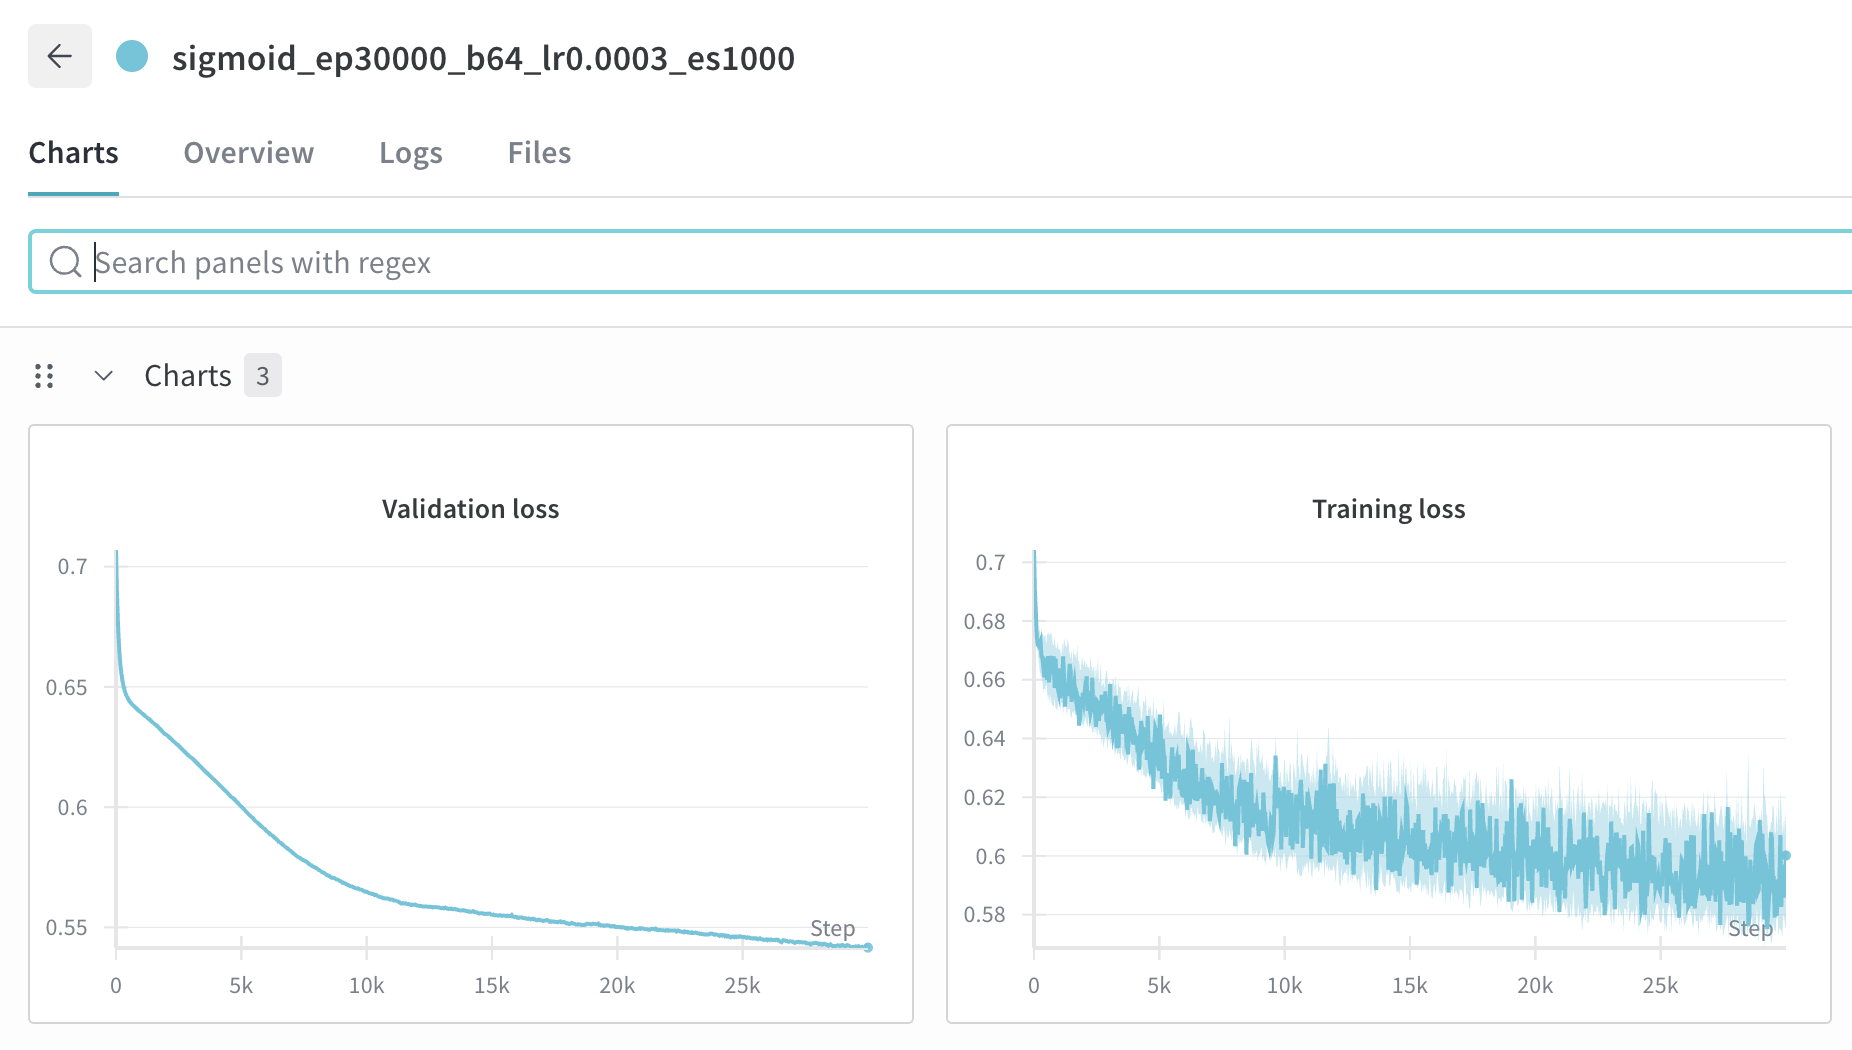
### elu
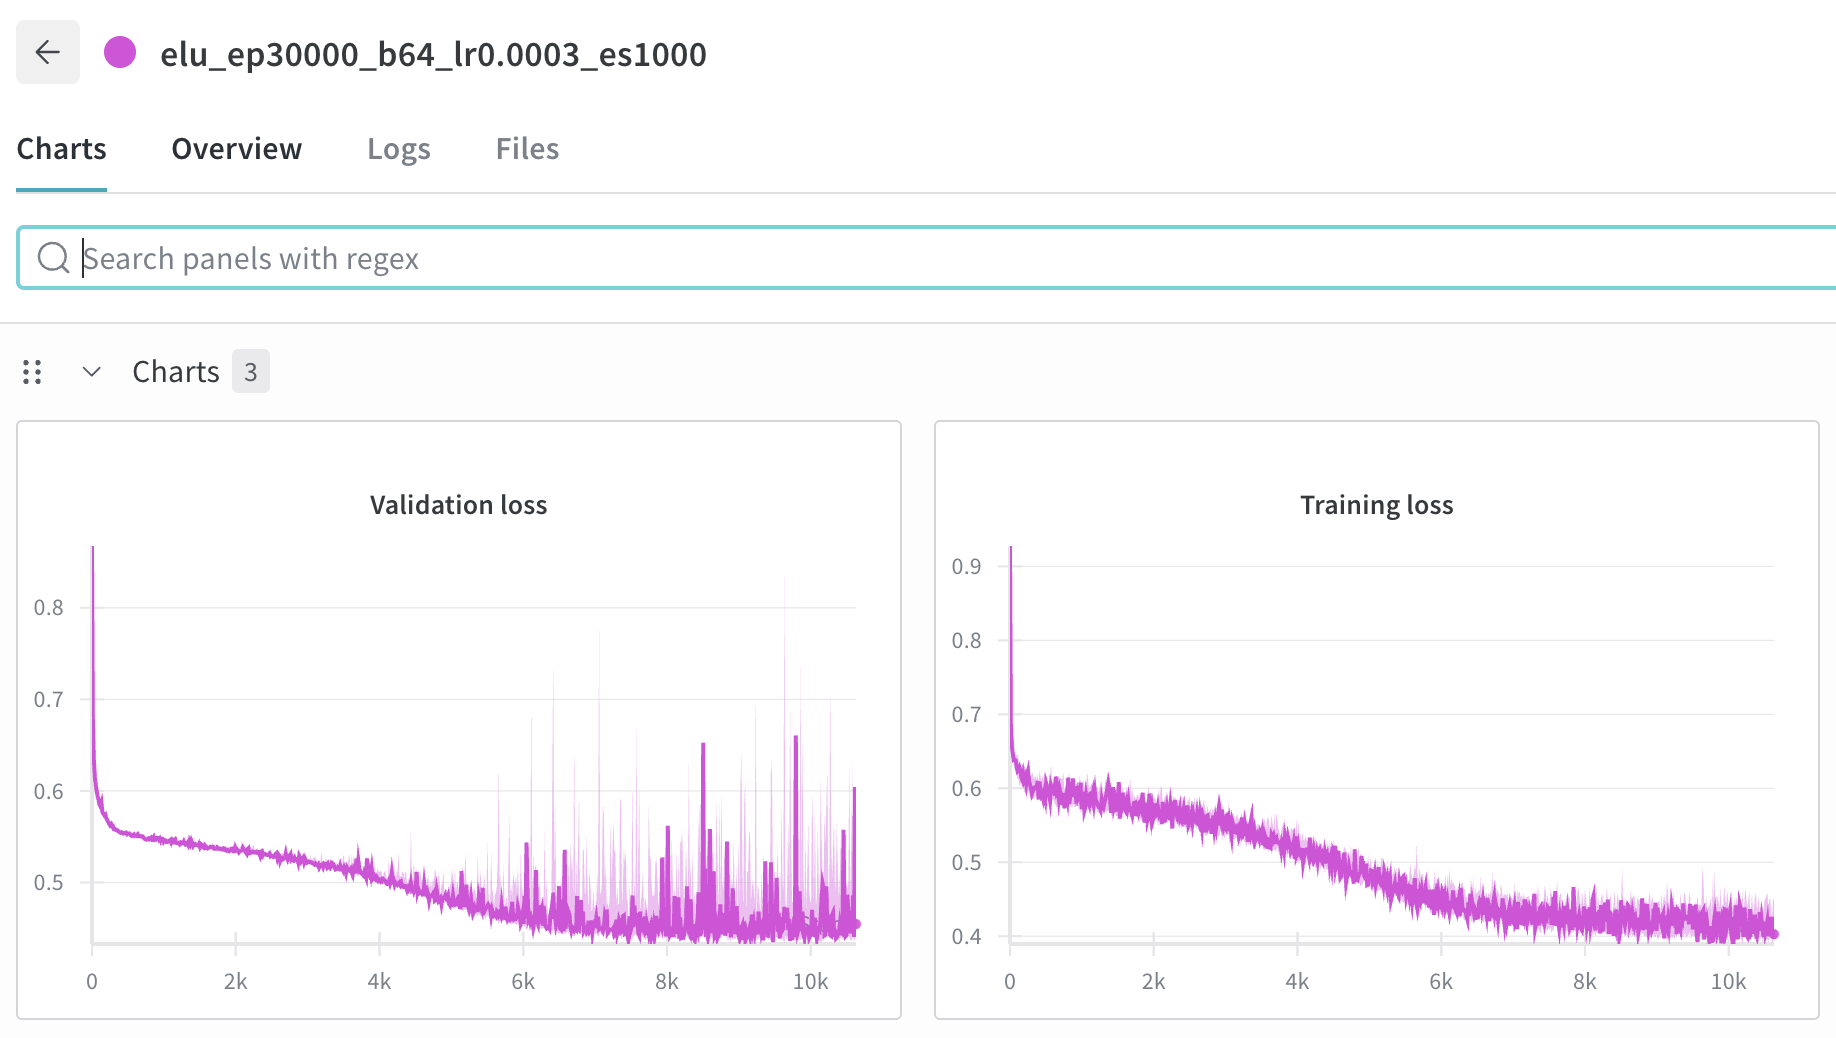
### relu
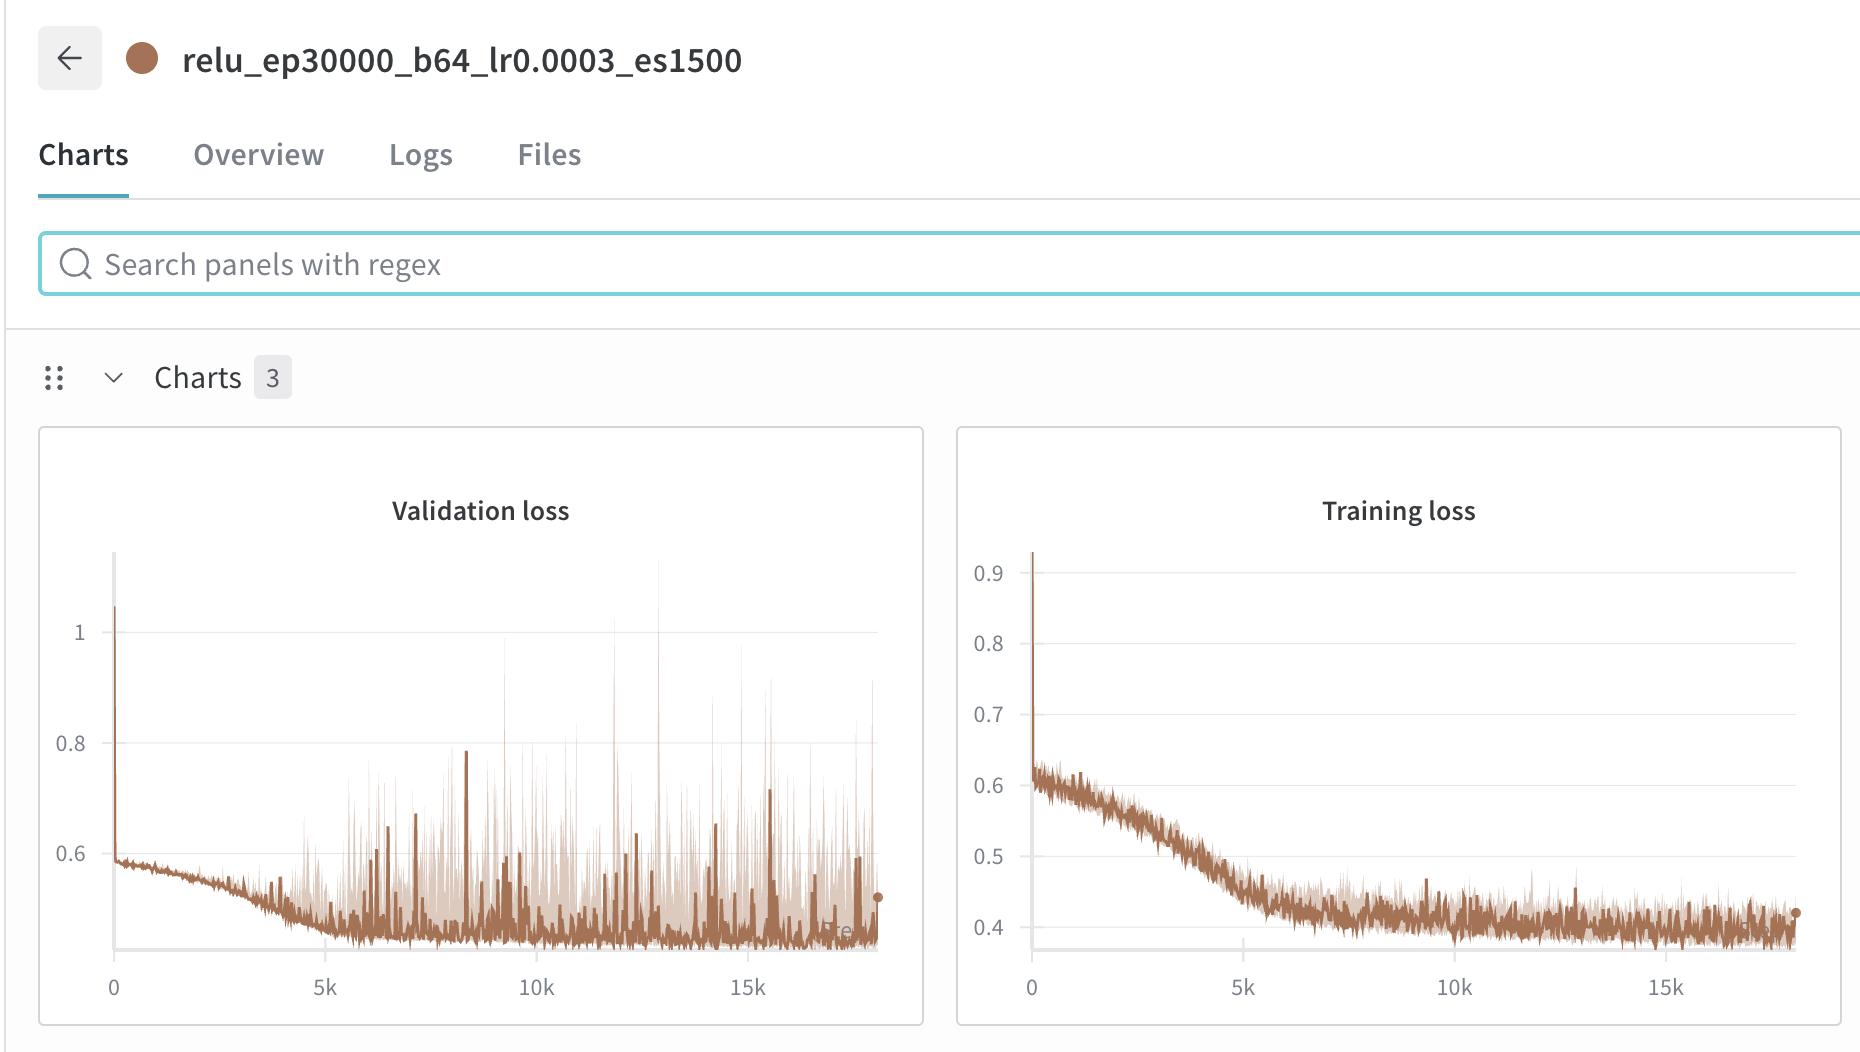
### leaky_relu
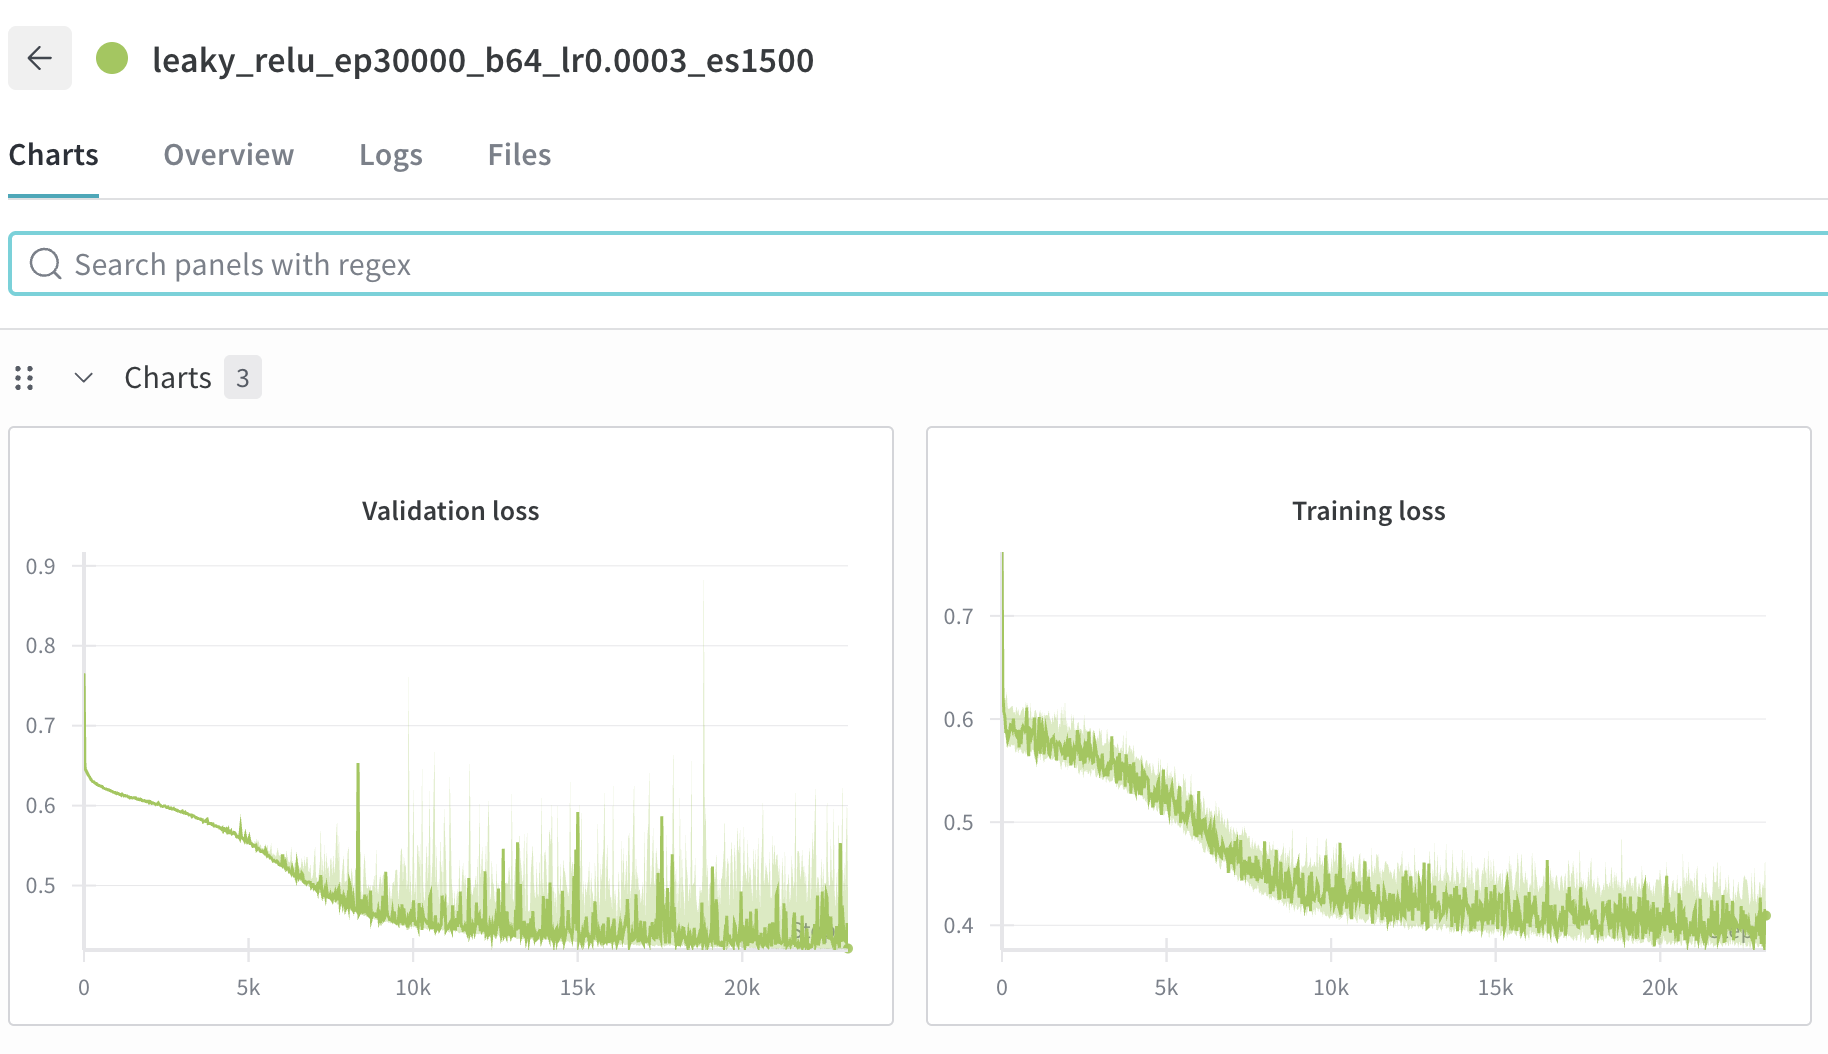